# Loading Files In and Formatting Data


In [13]:
# Open the .JDX Files and Rewrite to a CSV Like File Format
import csv
import math
import numpy as np
def load_file_in(filename):
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        #Extract Chemical Name
        #Absorbance Features
        wave_number = []
        absorbances = []
        desired_lines = []
        name = filename[8:-4]
        for line in reader:
            if '##XUNITS' in line[0]:
                xunits = line[0][9]
            if '##YUNITS' in line[0]:
                units = line[0][9]
            if line[0][0:2].isnumeric() or line[0][1] == '.':
                desired_lines.append(line)
        for line in desired_lines:
            split = line[0].split(' ')
            wave_number.append(float(split[0]))                
            absorbances.append(split[1:])
        average_absorbances = [] 
        #Averaging the five absorbance values to reduce dimensionality of data
        if xunits == 'M':
            adjusted = []
            for mm in wave_number:
                adjusted.append(10000/mm)
            wave_number = adjusted
        for absorbance in absorbances:
            new_absorbance = 0
            for absorbance_value in absorbance:
                if units == 'T':
                    absorbance_value = -math.log10(float(absorbance_value)+1e-10)
                new_absorbance += float(absorbance_value)
            new_absorbance = new_absorbance/len(absorbance)
            average_absorbances.append(new_absorbance)
        #Normalizing Absorbances to the largest value after 500 cm^-1
        max_I = 0
        for cm, I in zip(wave_number, average_absorbances):
            if cm > 500 and I > max_I:
                max_I = I
        norm_abs = []
        for abs in average_absorbances:
            norm_abs.append(abs/max_I)

        return norm_abs, wave_number, name
norm_abs, wave_number, name = load_file_in('spectra/propane_dinitrile.jdx')

### Test Spectra to make sure transformation is correct before running on all files

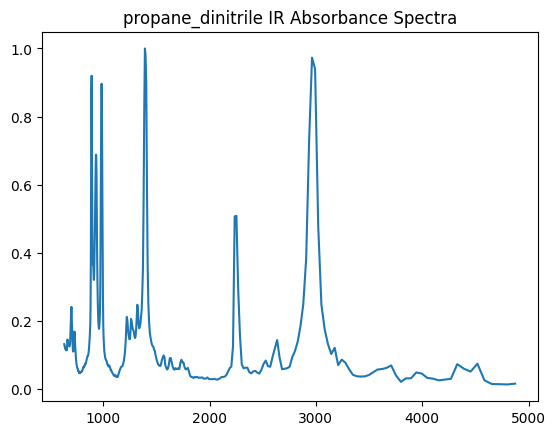

In [14]:
from matplotlib import pyplot as plt
plt.title(name +' IR Absorbance Spectra')
plt.plot(wave_number, norm_abs)
#Looks Good!

## Let's Load in the Rest of the 50 JDX Files

In [15]:
import glob

pattern = 'spectra/*.jdx'
chemicals = glob.glob(pattern)
names = []
norm_abs_list = []
wave_numbers = []
for chemical in chemicals:
    norm_abs, wave_number, name = load_file_in(chemical)
    names.append(name)
    norm_abs_list.append(norm_abs)
    wave_numbers.append(wave_number)



## Standardizing Wavenumber Scales. 
Unfortunately the spectra don't have the same number of data points on X so we need to reduce everything to the lowest common resolution to avoid overfitting. 

1-Ethynylcyclohexylamine
30


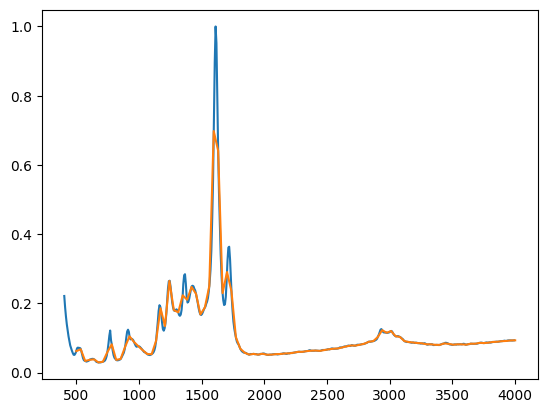

In [22]:
import numpy as np
from scipy.interpolate import interp1d
shortest_length = len(min(wave_numbers, key=len))
shortest_length = 100
max_wave = 4000
min_wave = 500
#Create a New Grid
shared_wave = np.linspace(max_wave, min_wave, shortest_length)
shared_wave = shared_wave.round(1)
#Put old peaks onto new grid with interpolation for all files
new_I = []
for chemical, x, I  in zip(names, wave_numbers, norm_abs_list):
    f = interp1d(x, I, kind='linear', fill_value='extrapolate')
    new_I.append(f(shared_wave))
    newnp_I = np.array(new_I)
    newnp_I[newnp_I < 0.025] = 0  #Set any negative values to zero
Intensities = list(newnp_I)
Intensities
#Check if the Interpoplated Reduced Data is still a decent fit! Seems Ok!
print(names[34])
print(names.index('hexane'))
plt.plot(wave_numbers[10], norm_abs_list[10])
plt.plot(shared_wave, newnp_I[10])

In [17]:

#We want to generate a new master file with the following format 
#NAME.            . ABSORBANCE                , CH, C=C, C≡C, C≡N, C-OH, C=O C=OOH, N-H, C≡C-H
#Structure1 Name | A1, A2, A3, A4, A5, A6, A7 | 1 0 1 0 1 0 
#Structure2 Name | A1, A2, A3, A4, A5, A6, A7 | FUNCTIONAL GROUPS #
row = []
functional = ['CH', 'C=C', 'C≡C', 'C≡N', 'C-OH', 'C=O', 'C=OOH', 'N-H', 'C≡C-H']
funct_dict = {'hexene': [1, 1, 0, 0, 0, 0, 0, 0, 0], 'heptane': [1, 0, 0, 0, 0, 0, 0, 0, 0], 'hexylamine': [1, 0, 0, 0, 0, 0, 0, 1, 0], 'acetylacetone': [1, 0, 0, 0, 0, 1, 0, 0, 0], 'octanol': [1, 0, 0, 0, 1, 0, 0, 0, 0], 'cyclohexylamine': [1, 0, 0, 0, 0, 0, 0, 1, 0], 'but-1-ene': [1, 1, 0, 0, 0, 0, 0, 0, 0], 'but-3-en-2-one': [1, 1, 0, 0, 0, 1, 0, 0, 0], '2-(ethylamino)ethan-1-ol': [1, 0, 0, 0, 1, 0, 0, 1, 0], 'acetone': [1, 0, 0, 0, 0, 1, 0, 0, 0], 'methanol': [1, 0, 0, 0, 1, 0, 0, 0, 0], 
            'hexane': [1, 0, 0, 0, 0, 0, 0, 0, 0], '2-cyclohexen-1-ol': [1, 1, 0, 0, 1, 0, 0, 0, 0], 'methane': [1, 0, 0, 0, 0, 0, 0, 0, 0], 'glycine': [1, 0, 0, 0, 1, 1, 1, 1, 0], 'hexanoic_acid': [1, 0, 0, 0, 1, 1, 1, 0, 0], 'methallyl_alcohol': [1, 1, 0, 0, 1, 0, 0, 0, 0], 'propanenitrile': [1, 0, 0, 1, 0, 0, 0, 0, 0], 'acetaldehyde': [1, 0, 0, 0, 0, 1, 0, 0, 0], 'ethylamine': [1, 0, 0, 0, 0, 0, 0, 1, 0], 'but-3-yn-2-one': [1, 0, 1, 0, 0, 1, 0, 0, 1], 'hex-3-ene': [1, 1, 0, 0, 0, 0, 0, 0, 0], 
            'butanol': [1, 0, 0, 0, 1, 0, 0, 0, 0], ' 3-methylbut-1-yne': [1, 0, 1, 0, 0, 0, 0, 0, 1], 'acetonitrile': [1, 0, 0, 1, 0, 0, 0, 0, 0], 'pentanenitrile': [1, 0, 0, 1, 0, 0, 0, 0, 0], 'butan-2-one': [1, 0, 0, 0, 0, 1, 0, 0, 0], 'methylamine': [1, 0, 0, 0, 0, 0, 0, 1, 0], 'cyclopentylcyanide': [1, 0, 0, 1, 0, 0, 0, 0, 0], '2_methylpropanenitrile': [1, 0, 0, 1, 0, 0, 0, 0, 0], 'methanoic_acid': [1, 0, 0, 0, 1, 1, 1, 0, 0], 'butanoic_acid': [1, 0, 0, 0, 0, 0, 1, 0, 0], '2_butynoic_acid': [1, 0, 1, 0, 1, 1, 1, 0, 0], 
            'hex-2-yne': [1, 0, 1, 0, 0, 0, 0, 0, 0], 'propylamine': [1, 0, 0, 0, 0, 0, 0, 1, 0], 'formamide': [1, 0, 0, 0, 0, 1, 0, 1, 0], 'pent-1-yne': [1, 0, 1, 0, 0, 0, 0, 0, 1], 'oct-2-ene': [1, 1, 0, 0, 0, 0, 0, 0, 0], 'butane': [1, 0, 0, 0, 0, 0, 0, 0, 0], 'ethene': [1, 1, 0, 0, 0, 0, 0, 0, 0], 'Acrylonitrile': [1, 1, 0, 1, 0, 0, 0, 0, 0], 'propyne': [1, 0, 1, 0, 0, 0, 0, 0, 1], 'ethane': [1, 0, 0, 0, 0, 0, 0, 0, 0], 'ethanol': [1, 0, 0, 0, 1, 0, 0, 0, 0], 'ethanoic_acid': [1, 0, 0, 0, 1, 1, 1, 0, 0], 'octanoic_acid': [1, 0, 0, 0, 1, 1, 1, 0, 0], 
            '2_Butyne': [1, 0, 1, 0, 0, 0, 0, 0, 0], '3_pentanone': [1, 0, 0, 0, 0, 1, 0, 0, 0], 'hexanol': [1, 0, 0, 0, 1, 0, 0, 0, 0], 'water': [0, 0, 0, 0, 1, 0, 0, 0, 0], 'Propiolonitrile': [0, 0, 1, 1, 0, 0, 0, 0, 1], '5-Hexyn-1-ol': [1, 0, 1, 0, 1, 0, 0, 0, 1], 'cyclopentylacetylene': [1, 0, 1, 0, 0, 0, 0, 0, 0], 'cyclohexylacetylene': [1, 0, 1, 0, 0, 0, 0, 0, 0], '1-Ethynylcyclohexylamine': [1, 0, 1, 0, 0, 0, 0, 1, 1], 'Cyanogen': [0, 0, 0, 1, 0, 0, 0, 0, 0], 'propanenitrile_2methyl': [1, 0, 0, 1, 0, 0, 0, 0, 0], 'Methacrylonitrile': [1, 1, 0, 1, 0, 0, 0, 0, 0], 
            'Cyclopropanecarbonitrile': [1, 0, 0, 1, 0, 0, 0, 0, 0], 'Acetamide_2-Cyano': [1, 0, 0, 1, 0, 1, 0, 1, 0], 'hexanenitrile_5oxo': [1, 0, 0, 1, 0, 1, 0, 0, 0], '2_propene_1_ol': [1, 1, 0, 0, 1, 0, 0, 0, 0], '1_3propanediol': [1, 0, 0, 0, 1, 0, 0, 0, 0], 'cyclobutanol': [1, 0, 0, 0, 1, 0, 0, 0, 0], '3-Methyl-2-buten-1-ol': [1, 1, 0, 0, 1, 0, 0, 0, 0], 'ethanol_2_2aminoethylamino': [1, 0, 0, 0, 1, 0, 0, 1, 0], '2-Propen-1-amine': [1, 1, 0, 0, 0, 0, 0, 1, 0], '2-Propenal': [1, 1, 0, 0, 0, 1, 0, 0, 0], '2-Buten-1-ol': [1, 1, 0, 0, 1, 0, 0, 0, 0], 
            '2-Pentenenitrile': [1, 1, 0, 1, 0, 0, 0, 0, 0], '1,5-Hexadiene': [1, 1, 0, 0, 0, 0, 0, 0, 0], 'Butanal-3-hydroxy-': [1, 0, 0, 0, 1, 1, 0, 0, 0], 'Cyclohexanecarboxaldehyde-4-Hydroxy Methyl': [1, 0, 0, 0, 1, 1, 0, 0, 0], 'but-2-ene': [1, 1, 0, 0, 0, 0, 0, 0, 0], 'cyclopentadiene': [1, 1, 0, 0, 0, 0, 0, 0, 0], '3-methylcyclopentene': [1, 1, 0, 0, 0, 0, 0, 0, 0], '5_cyano_pentene': [1, 1, 0, 1, 0, 0, 0, 0, 0], '3-Hexen-1-ol(Z)': [1, 1, 0, 0, 1, 0, 0, 0, 0], '1_5hexadiene3ol': [1, 1, 0, 0, 1, 0, 0, 0, 0], '3-Methylenecyclobutanenitrile': [1, 1, 0, 1, 0, 0, 0, 0, 0],
            'Cyclohexanemethylene': [1, 1, 0, 0, 0, 0, 0, 0, 0], 'mecrylate': [1, 1, 0, 1, 0, 1, 0, 0, 0], 'dimethylpyrrole': [1, 1, 0, 0, 0, 0, 0, 1, 0], 'Urea':[0, 0, 0, 0, 0, 1, 0, 1, 0], 'trimethylborane': [1, 0, 0, 0, 0, 0, 0, 0, 0], 'Acetaldoxime':[1,0,0,0,1,0,0,0,0], 'acetamide':[1, 0, 0, 0, 0, 1, 0, 1, 0], 'propargyl_alcohol':[1,0,1,0,1,0,0,0,1], 'isopropyl_alcohol':[1,0,0,0,1,0,0,0,0], '2_Butene_E':[1,1,0,0,0,0,0,0,0], 'Urea_Methyl':[1, 0, 0, 0, 0, 1, 0, 1, 0], 'Cyanamide_Dimethyl':[1,0,0,1,0,0,0,0,0], 'formamide_dimethyl':[1,0,0,0,0,1,0,0,0], 
            '2-Propyn-1-amine_N-methyl-': [1,0,1,0,0,0,0,1,1], 'propane_dinitrile':[1,0,0,1,0,0,0,0,0], '1-Propanol-2-amino-(S)-':[1,0,0,0,1,0,0,1,0], 'propanamide':[1,0,0,0,0,1,0,1,0], '3_butyn-1-ol':[1,0,1,0,1,0,0,0,1], '2-butyn-1-ol':[1,0,1,0,1,0,0,0,0], '3-butyn-2-ol':[1,0,1,0,1,0,0,0,1], 'butyn-3methyl':[1,0,1,0,0,0,0,0,1], '1-butene-3-methyl':[1,1,0,0,0,0,0,0,0], '3-Penten-1-yne-E':[1,1,1,0,0,0,0,0,1], '2_butenal':[1,1,0,0,0,1,0,0,0], '2-Propen-1-ol-2-methyl-':[1,1,0,0,1,0,0,0,0], '1-Pentyne':[1,0,1,0,0,0,0,0,1],'2-propanol-1-amino':[1,0,0,0,1,0,0,1,0]}
# List of molecule names that have C≡C-H
# You can make this list manually or detect via name pattern (e.g., "yne" or "ethynyl")
print
for i, j in zip(names, Intensities):
    j = list(j)
    j.insert(0, i)
    functional_groups = funct_dict[i]
    j.extend(functional_groups)
    row.append(j)
index = ['Name']
for i in shared_wave:
    index.append(i)
index.extend(functional)
#Write to a Summary File
with open('Full_File.csv', 'w') as write_file:
    writer = csv.writer(write_file)
    writer.writerow(index)
    for r in row:
        writer.writerow(r)
